# Representational Similarity Analysis
*Written by Luke Chang*

Representational Similarity Analysis (RSA) is a multivariate technique that allows one to link disparate types of data based on shared structure in their similarity (or distance) matrices. This technique was initially proposed by [Nikolaus Kriegskorte in 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research). Unlike multivariate prediction/classification, RSA does not attempt to directly map brain activity onto a measure, but instead compares the similarities between brain activity and the measure using second-order isomorphisms. This sounds complicated, but is actually quite conceptually simple. 

For a more in depth tutorial, we recommend reading this excellent [tutorial](https://github.com/Summer-MIND/mind_2018/tree/master/tutorials/representational_similarity) written by [Mark Thornton](http://markallenthornton.com/) for the [2018 MIND Summer School](http://mindsummerschool.org/2018/07/30/narratives-and-naturalistic-contexts.html), or watching his [video walkthrough](https://www.youtube.com/watch?v=ufGtuT_J75w&index=29&t=0s&list=PLEE6ggCEJ0H0KOlMKx_PUVB_16VoCfGj9).

Let's work through a quick example to outline the specific steps involved in RSA to make this more concrete.

## RSA Overview
Imagine that you view 96 images in the scanner. We can use a standard first level GLM to estimate a separate beta map for each image while simultaneously removing noise from the signal by including nuisance covariates (e.g., head motion, spikes, discrete cosine transform filters, etc.)

![design_matrix.jpg](../../images/rsa/design_matrix.jpg)
from [Kriegeskorte et al., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)

After we have a single beta map for each image, we can extract patterns of activity for a single ROI to yield an image by ROI voxel matrix. This allows us to calculate the representational space of how this region responds to each image by computing the pairwise similarity of the pattern of activation viewing one picture to all other pictures. In other words, each voxel within a region becomes an axis in a high dimensional space, and how the region responds to a single picture will be a point in that space. Images that have a similar response in this region will be closer in this high dimensional voxel space.

![brain_extraction](../../images/rsa/brain_extraction.jpg)
from [Haxby et al., 2014](https://www.annualreviews.org/doi/full/10.1146/annurev-neuro-062012-170325)

The  distance of each stimuli to every other stimuli in this space can be calculated using a pairwise distance metric (e.g., euclidean, correlation, cosine, etc). Computing a pairwise distance or dissimilarity of a given brain region across stimuli will yield an image x image matrix. There are many different metrics to calculate distance. For example, the absolute distance is often computed using [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), but if we don't care about the absolute magnitude in each dimension, the relative distance can be computed using [correlation distance](https://cmci.colorado.edu/classes/INFO-1301/files/borgatti.htm). Finally, distance is inversely proportional to similarity and these can be used relatively interchangeability (note that we will probably switch back and forth between describing similarity and distance between stimuli).

![brain_similarity](../../images/rsa/brain_similarity.jpg)
from [Kriegeskorte et al., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)

Now we can test different hypotheses about how the brain might be processing information about each image by mapping the representational structure of the brain space to different features spaces.

For example, if we were interested in regions that process visual information, we might extract different low-level visual features of an image (e.g., edges, luminance, salience, color, etc). 

![visual_features.jpg](../../images/rsa/visual_features.jpg)
from [Kriegeskorte et al., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)

We can compute the *representational space* of this set of features by computing the pairwise similarity between each image in this feature space. Just like the voxel space, each feature becomes an axis and images reflect points in this high dimensional feature space. Images with similar visual properties would likely be located in a similar position in this space. Again, this can be represented through a pairwise image by image similarity or distance matrix. 

![visual_features_pairwise_similarity.jpg](../../images/rsa/visual_features_pairwise_similarity.jpg)
from [Kriegeskorte et al., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)

Now to make an inference about what each region of the brain is computing, we can evaluate if there are any regions in the brain that exhibit a similar structure as the feature representational space. Remember, these matrices are typically symmetrical (unless there is a directed relationship), so you can extract either the upper or lower triangle of these matrices. Then these triangles are flattened or vectorized, which makes it easy to evaluate the similarity between the triangle of the brain and feature matrices. Because these relationships might not necessarily be linear, it is common to use a spearman rank correlation to examine monotonic relationships between different similarity matrices. 

![similarity.jpg](../../images/rsa/similarity.jpg)
from [Kriegeskorte et al., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)

We can make inferences across subjects, by transforming each correlation value for a given region to a continuous metric using a [fisher r-to-z transformation](https://en.wikipedia.org/wiki/Fisher_transformation) and then computing a one-sample t-test over participants to test if the observed distribution is significantly different from zero. This is typically computed using resampling methods such as a permutation test. If inferences are over participants, then a sign test similar to a one-sample t-test is appropriate. This is a fairly standard practice when all participants viewed the same stimuli and you are interested in making inferences over participants.

There are extensions to apply this method to other types of data. For example, in Intersubject-RSA (IS-RSA), one might be interested in whether participants exhibit a particular representational structure over some feature space that maps on to inter-subject differences in brain patterns [van Baar et al., 2019](https://www.nature.com/articles/s41467-019-09161-6). In this particular, extension we cannot use the same type of permutation test to make our inferences (unless we have many different groups of participants). Instead, we might randomly shuffle one of the matrices and repeatedly re-calculate the similarity to produce an empirical distribution of similarity values. It is important to note that this type of permutation violates the exchangeability hypothesis and might yield overly optimistic p-values [see Chen et al., 2017](https://www.sciencedirect.com/science/article/pii/S1053811916304141). Instead, a more conservative hypothesis testing approach is to use the [mantel test](https://en.wikipedia.org/wiki/Mantel_test), in which we only permute the rows and columns with respect to one another. Personally, I think this approach is too conservative for small sample sizes and it is still an open statistical question about how to best make inferences in this particular type of use.

![rsa.jpg](../../images/rsa/rsa.jpg)
from [Kriegeskorte et al., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)

One of the reasons why this technique is so powerful is that it allows the possibility of testing different computational hypotheses. Different feature representations might be associated with specific regions involved in various computations. Alternatively, different types of data can be mapped onto each other using this technique. For example, [Kriegeskorte et al., 2008](https://www.sciencedirect.com/science/article/pii/S0896627308009434) have demonstrated that it is possible to map the function of IT cortex across humans and monkeys using this technique.

Now that we understand the basic steps of RSA, let's apply it to some test data. First, let's load the modules we will use for this tutorial.

In [225]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

netid = 'f00275v'
base_dir = '/dartfs/rc/lab/P/Psych60/'
output_dir = os.path.join(base_dir, 'students_output', netid)
data_dir = os.path.join(base_dir, 'data','brainomics_data')

## Single Subject Pattern Similarity
Recall from Lab 10, that we ran single subject models for 10 different regressors for the Pinel Localizer task.  In this tutorial, we will use our results to learn how to conduct RSA style analyses.

First, let's get a list of all of the subject IDs and load the beta values from each condition for a single subject into a `Brain_Data` object.

In [96]:
sub_list = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir, 'S*'))]
sub_list.sort()
sub = sub_list[0]

file_list = glob.glob(os.path.join(data_dir, sub, f'{sub}_beta*nii.gz'))
file_list.sort()

conditions = [os.path.basename(x)[:-7].split('_beta_')[-1] for x in file_list]

beta = Brain_Data(file_list)

Next we will compute the pattern similarity across each beta image. We could do this for the whole brain, but it probably makes more sense to look within a single region. Many papers use a searchlight approach in which they examine the pattern similarity within a small sphere centered on each voxel. The advantage of this approach is that it uses the same number of voxels across searchlights and allows one to investigate the spatial topography at a relatively fine-scale. However, this procedure is fairly computationally expensive as it needs to be computed over each voxel and just like univariate analyses, will require stringent correction for multiple tests as we learned about in tutorial 12: Thresholding Group Analyses. Personally, I prefer to use whole-brain parcellations as they provide a nice balance between spatial specificity and computational efficiency. In this tutorial, we will continue to use functional regions of interest from our 50 ROI Neurosynth parcellation. This allows us to cover the entire brain with a relatively course spatial granularity, but requires several orders of magnitude of less computations than using a voxelwise searchlight approach. This means it will run much faster and will require us to use a considerably less stringent statistical threshold to correct for all independent tests. For example, for 50 tests bonferroni correction is p < 0.001 (i.e., .05/50). If we ever wanted better spatial granularity we could use increasingly larger parcellations (e.g., [100 or 200](https://neurovault.org/collections/2099/)).

Let's load our parcellation mask so that we can examine the pattern similarity across these conditions for each ROI.

threshold is ignored for simple axial plots


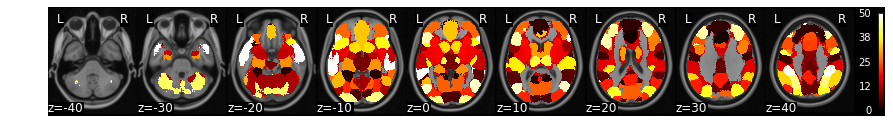

In [24]:
mask = Brain_Data(os.path.join(base_dir, 'resources', 'masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

f = mask.plot()

Ok, now we will want to calculate the pattern similar within each ROI across the 10 conditions.

We will loop over each ROI and extract the pattern data across all conditions and then compute the correlation distance between each condition. This data will now be an `Adjacency` object that we discussed in the Lab 13: Connectivity. We will temporarily store this in a list.

Notice that for each iteration of the loop we apply the ROI mask to our beta images and then calculate the correlation distance. 

In [104]:
out = []
for m in mask_x:
    out.append(beta.apply_mask(m).distance(method='correlation'))

Let's plot an example ROI and it's associated distance matrix.

Here is a left motor parcel. Notice how the distance is small between the motor left auditory and visual and motor right auditory and visual beta images?

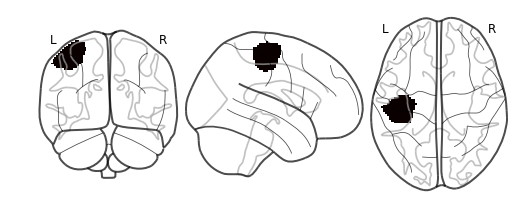

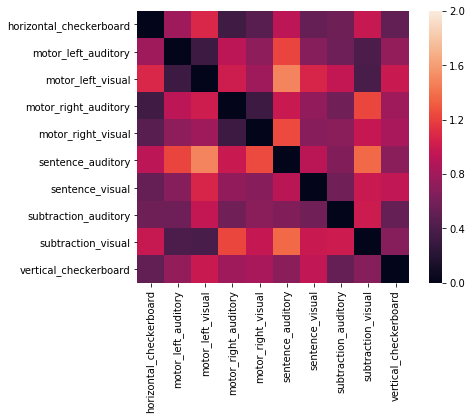

In [121]:
roi = 26
plot_glass_brain(mask_x[roi].to_nifti())
out[roi].labels = conditions
f2 = out[roi].plot(vmin=0, vmax=2)

We can also visualize this distance matrix using multidimensional scaling with the `plot_mds()` method. This method projects the images into either a 2D or 3D plane for ease of visualization. There are many other distance based projection methods such as T-SNE or UMAP, we encourage readers to check out the excellent [hypertools](https://hypertools.readthedocs.io/en/latest/) package that has a great implementation of all of these methods.

Notice how the motor right visual and auditory are near each other, while the motor left visual and auditory are grouped together further away?

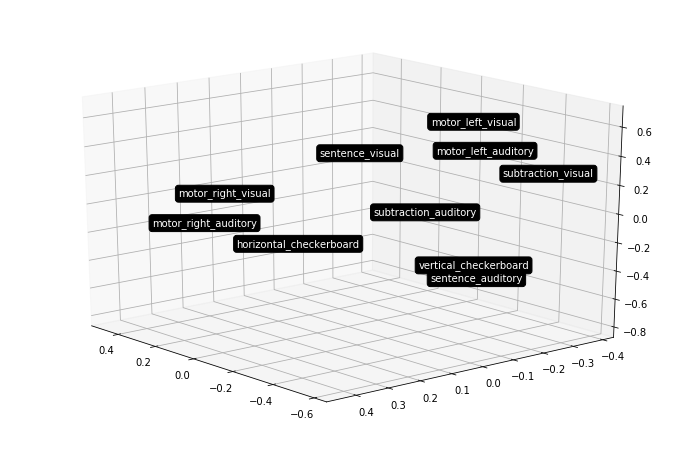

In [145]:
f = out[roi].plot_mds(n_components=3, view=(20, 140))

It's completely fine to continue to work with distance values, but just to make this slightly more intuitive to understand what is going on we will convert this to similarity.  For correlation distance, this entails subtracting each value from 1. This will yield similarity scores in the form of pearson correlations. If you are using unbounded metrics (e.g., euclidean distance), then use the `distance_to_similarity()` Adjacency method.

We are also adding conditions as labels to the object, which make the plots easier to read.

In [146]:
out_sim = []
for m in out:
    mask_tmp = m.copy()
    mask_tmp.data = 1 - mask_tmp.data
    mask_tmp.labels = conditions
    out_sim.append(mask_tmp)

Let's look at the heatmap of the similarity matrix to see how more red colors indicate greater similarity between patterns within the left motor cortex across conditions.

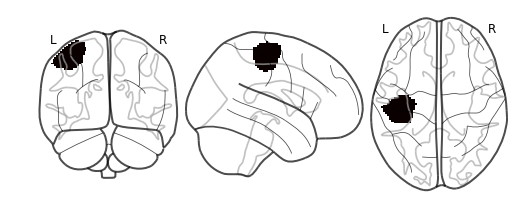

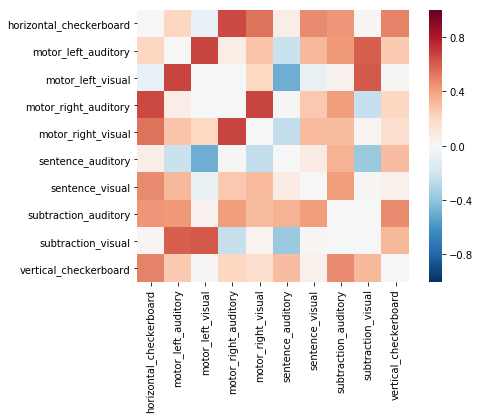

In [148]:
roi = 26
plot_glass_brain(mask_x[roi].to_nifti())
f = out_sim[roi].plot(vmin=-1, vmax=1, cmap='RdBu_r')

## Testing a Representation Hypothesis

Ok, now that we have a sense of what the similarity of patterns look like in left motor cortex, let's create an adjacency matrix indicating a specific relationship between left hand finger tapping across the auditory and visual conditions. This type of adjacency matrix is one way in which we can test a specific hypotheses about the representational structure of the data across all images.

As you can see this only includes edges for the motor-left auditory and motor-left visual conditions.

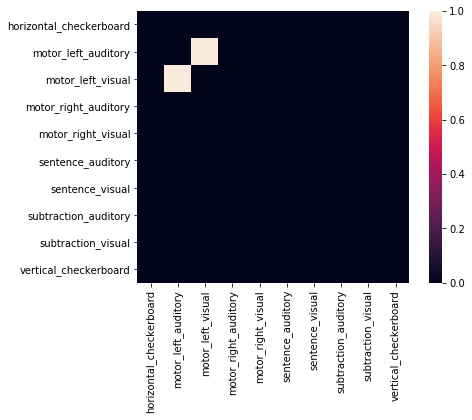

In [82]:
motor_left = np.zeros((len(conditions),len(conditions)))
motor_left[np.diag_indices(len(conditions))] = 1 
motor_left[1,2] = 1
motor_left[2,1] = 1
motor_left = Adjacency(motor_left, matrix_type='similarity', labels=conditions)
f = motor_left.plot()

Now let's search over all ROIs to see if any match this representational structure of left motor-cortex using the `similarity()` method from the `Adjacency` class. This function uses spearman rank correlations by default. This is probably a good idea as we are most interested in monotonic relationships between the two similarity matrices.

The `similarity()` method also computes permutations within columns and rows by default. To speed up the analysis, we will set the number of permutations to zero (i.e., `n_permute=0`).

In [151]:
motor_left_sim_r = []
for m in out_sim:
    s = m.similarity(motor_left, metric='spearman', n_permute=0)
    motor_left_sim_r.append(s['correlation'])

This will return a vector of similarity scores for each ROI, we can plot the distribution of these 50 $\rho$ values.

Text(0, 0.5, 'Frequency')

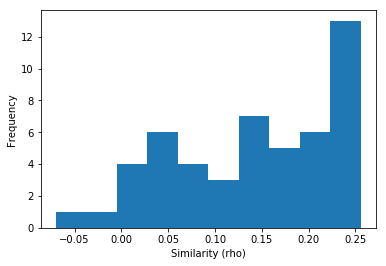

In [156]:
plt.hist(motor_left_sim_r)
plt.xlabel('Similarity (rho)')
plt.ylabel('Frequency')

We can also plot these RSA values back onto the brain to see the spatial distribution.

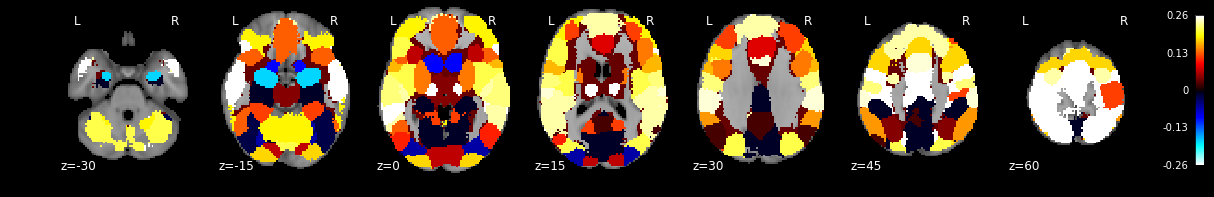

In [232]:
rsa_left_motor = Brain_Data([x*y for x,y in zip(mask_x, motor_left_sim_r)]).sum()

plot_stat_map(rsa_left_motor.to_nifti(), draw_cross=False, display_mode='z', black_bg=True, cut_coords=np.arange(-30,70, 15))


Notice how left motor cortex is among the ROIs with the highest similarity value?  Unfortunately, we can only plot the similarity values and can't threshold them yet because we didn't calculate any p-values.

We could calculate p-values using a permutation test, but this would require us to repeatedly recalculate the similarity between the two matrices and would take a long time (i.e., 5,000 correlations X 50 ROIS). Plus, the inference we want to make isn't really at the single-subject level, but across participants.

Let's now run this same analysis across all participants and run a one-sample t-test across each ROI.

## RSA Group Inference
Here we calculate the RSA for each ROI for every participant.  This will take a little bit of time to run (30 participants X 50 ROIs).

In [160]:
sub_list = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir, 'S*'))]
sub_list.sort()
sub = sub_list[0]

all_sub_similarity = {}; all_sub_motor_left_rsa = {};
for sub in sub_list:
    file_list = glob.glob(os.path.join(data_dir, sub, f'{sub}_beta*nii.gz'))
    file_list.sort()

    conditions = [os.path.basename(x)[:-7].split('_beta_')[-1] for x in file_list]

    beta = Brain_Data(file_list)
    
    sub_pattern = []; motor_left_sim_r = [];
    for m in mask_x:
        sub_pattern_similarity = beta.apply_mask(m).distance(method='correlation')
        sub_pattern_similarity.data = 1 - sub_pattern_similarity.data
        sub_pattern_similarity.labels = conditions
        s = sub_pattern_similarity.similarity(motor_left, metric='spearman', n_permute=0)
        sub_pattern.append(sub_pattern_similarity)
        motor_left_sim_r.append(s['correlation'])
    
    all_sub_similarity[sub] = sub_pattern
    all_sub_motor_left_rsa[sub] = motor_left_sim_r
all_sub_motor_left_rsa = pd.DataFrame(all_sub_motor_left_rsa).T

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.

IndexError: list index out of range

Now let's calculate a one sample t-test on each ROI, to see which ROI is consistently different from zero across our sample of participants. Because these are r-values, we will first perform a [fisher r to z transformation](https://en.wikipedia.org/wiki/Fisher_transformation). We will use a [non-parametric permutation sign test](https://en.wikipedia.org/wiki/Sign_test) to perform our null hypothesis test. This will take a minute to run as we will be calculating 5000 permutations for each of 50 ROIs (though these permutations are parallelized across cores).

In [173]:
rsa_stats = []
for i in all_sub_motor_left_rsa:
    rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_motor_left_rsa[i])))

We can plot a thresholded map using fdr correction as the threshold

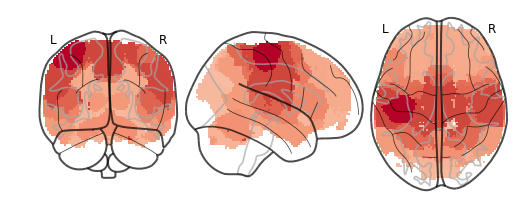

In [215]:
fdr_p = fdr(np.array([x['p'] for x in rsa_stats]), q=0.05)
print(fdr_p)

rsa_left_motor_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, rsa_stats)]).sum()
rsa_left_motor_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, rsa_stats)]).sum()

thresholded = threshold(rsa_left_motor_r, rsa_left_motor_p, thr=fdr_p)

plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm')

This produces a p-value of 0.0138. Because we have so many regions that survive this threshold, we might want to use a more conservative one such as bonferroni (i.e., p < 0.001). 

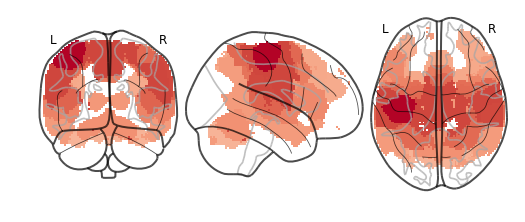

In [219]:
thresholded = threshold(rsa_left_motor_r, rsa_left_motor_p, thr=0.001)

plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm')

This looks a little better and makes it clear that the ROI that has the highest similarity with our model specifying the representational structure of left motor cortex is precisely the left motor cortex.

Though this was a very simple model using a very simple dataset, hopefully this example has illustrated how straightforward it is to run RSA style analyses using any type of data. Most people use this method to examine representations of much more complicated feature spaces.

It is also possible to combine different hypotheses or models to decompose a brain representational similarity matrix. This method typically uses regression rather than correlations (see [Parkinson et al., 2017](https://www.nature.com/articles/s41562-017-0072)

We have recently used this technique in our own work to map similarity in brain space to individual variability in a computational model of decision-making. If you are interested in seeing an example of intersubject RSA (IS-RSA), check out the [paper](https://www.nature.com/articles/s41467-019-09161-6), and accompanying python [code](https://github.com/jeroenvanbaar/MoralStrategiesFMRI).